In [1]:
import tensorflow as tf
keras = tf.keras

In [2]:
import numpy as np
import os
from pathlib import Path
import glob

In [3]:
import matplotlib.pyplot as plt

def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

#------------------------------------------------------------#

def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, labels, lengths=None):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    if lengths is not None:
        for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
            plt.subplot(n_rows, n_cols, index + 1)
            draw_sketch(sketch[:length], label)
    else:
        for index, sketch, label in zip(range(n_sketches), sketches, labels):
            plt.subplot(n_rows, n_cols, index + 1)
            draw_sketch(sketch, label)
    plt.show()

# Sketch RNN: Classifier

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065312256/1065301781 [==============================] - 129s 0us/step


In [48]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [49]:
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    classes = train_classes_file.readlines()

In [50]:
class_names = [name.strip().lower() for name in classes]
sorted(class_names[:6])

['garden hose', 'lighter', 'penguin', 'sheep', 'skateboard', 'tractor']

In [62]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [57]:
def crop_long_sketches(dataset, max_length=100):  # there's just a few sketches that have more than 100 time steps
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))  # prepares for training as well

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [58]:
i = 3
for x, y in cropped_train_set.take(1):
    print(x[i], class_names[y[i]], sep='\n')  # x is arranged in (x_coor, y_coor, is_pen_up)
    break

tf.Tensor(
[[-0.04705882 -0.00840336  0.        ]
 [-0.04705882 -0.08403361  0.        ]
 [-0.02745099 -0.1512605   0.        ]
              ...                        [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]], shape=(94, 3), dtype=float32)
bus


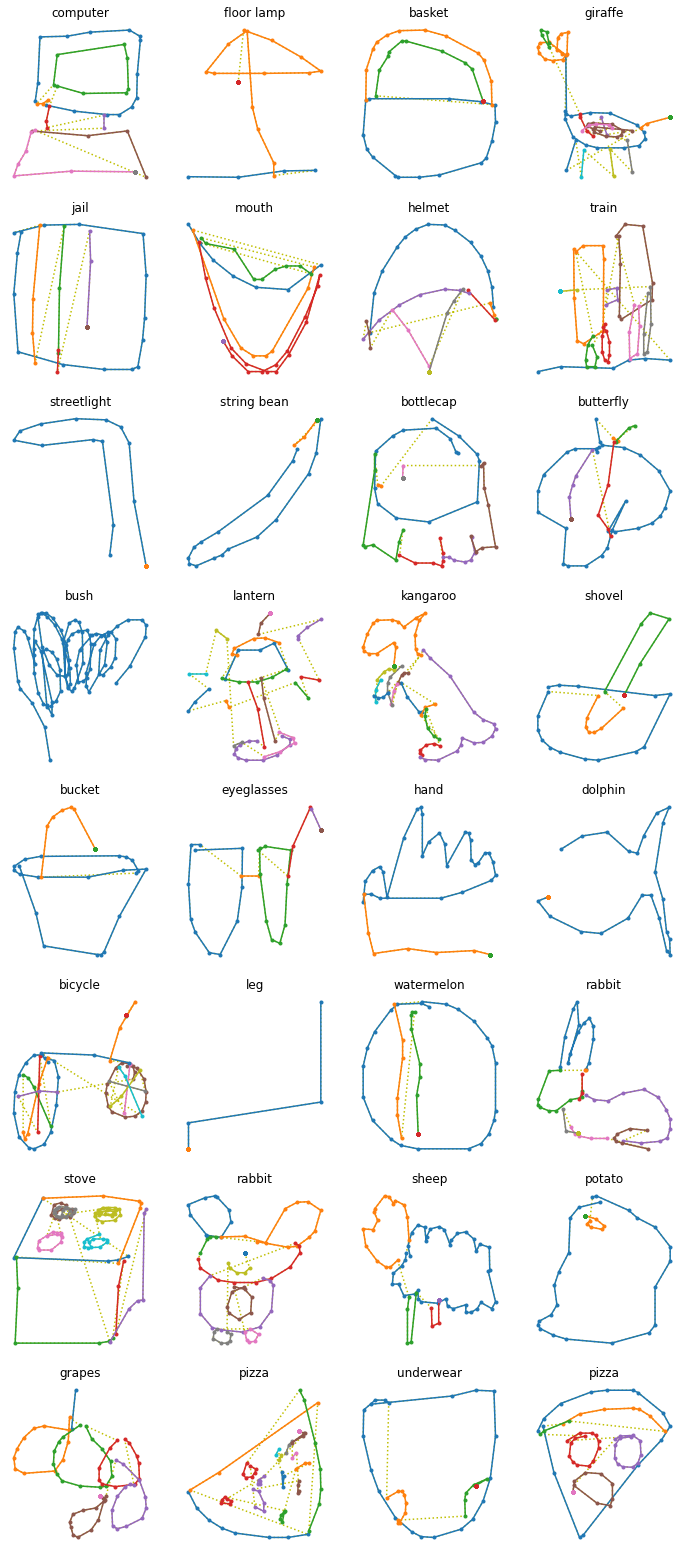

In [63]:
for sketches, labels in cropped_train_set.take(1):
    draw_sketches(sketches, labels)

In [87]:
class LN_LSTM(keras.layers.Layer):  # LSTM with layer normalization
    
    def __init__(self, units, activation="tanh", **kwargs): 
        super().__init__(**kwargs) 
        
        self.state_size = units 
        self.output_size = units 
        self.LSTM_cell = keras.layers.LSTM(units, activation = None) 
        self.layer_norm = keras.layers.LayerNormalization() 
        self.activation = keras.activations.get(activation) 
        
    def call(self, inputs, states): 
        outputs, new_states = self.LSTM_cell(inputs, states) 
        norm_outputs = self.activation(self.layer_norm(outputs)) 
        return norm_outputs, [norm_outputs]

In [109]:
model = keras.models.Sequential([
    keras.layers.Conv1D(50, kernel_size=6, strides=3, activation='relu', input_shape=[None, 3]),
    # The visual patterns are already very simple. So I think it's viable to use a lot of filters
    # right from the beginning, since the layer is already looking at high level features.
    # Oh, I'm using convolutional layers to reduce the "temporal dimension"
    # (3 features and 100 time steps -> 150 features and about 16 time steps)
    keras.layers.Conv1D(120, kernel_size=6, strides=3, activation='relu'),
    #keras.layers.RNN(LN_LSTM(150), return_sequences=True),
    #keras.layers.RNN(LN_LSTM(150)),
    keras.layers.LSTM(120),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model_with_BN = keras.models.Sequential([
    keras.layers.Conv1D(50, kernel_size=6, strides=3, activation='relu', input_shape=[None, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(120, kernel_size=6, strides=3, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(120),
    keras.layers.Dense(len(class_names), activation='softmax')
])

optimizer = keras.optimizers.Nadam(learning_rate=0.0005, clipnorm=1.)  
# a smaller learning rate than usual plus gradient clipping to avoid explosion
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

model_with_BN.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

In [110]:
model_with_BN.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, None, 50)          950       
_________________________________________________________________
batch_normalization_2 (Batc  (None, None, 50)          200       
hNormalization)                                                  
_________________________________________________________________
conv1d_41 (Conv1D)           (None, None, 120)         36120     
_________________________________________________________________
batch_normalization_3 (Batc  (None, None, 120)         480       
hNormalization)                                                  
_________________________________________________________________
lstm_32 (LSTM)               (None, 120)               115680    
_________________________________________________________________
dense_20 (Dense)             (None, 345)             

In [106]:
optimizer = keras.optimizers.Nadam(learning_rate=0.0001, clipnorm=1.)  # update: reduced learning rate
# a smaller learning rate than usual plus gradient clipping to avoid explosion
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

In [ ]:
history = model.fit(cropped_train_set, epochs=1, validation_data=cropped_valid_set)  # Fitted for ~ONE epoch

In [111]:
model.save("my_sketchrnn")

INFO:tensorflow:Assets written to: my_sketchrnn\assets


INFO:tensorflow:Assets written to: my_sketchrnn\assets


In [115]:
optimizer = keras.optimizers.Nadam(learning_rate=0.0001, clipnorm=1.)  # update: reduced learning rate

model_with_BN.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

In [116]:
full_epochs = 1
history = model_with_BN.fit(cropped_train_set, epochs=full_epochs*3, 
                            validation_data=cropped_valid_set, steps_per_epoch=35937)

Epoch 1/3
35937/35937 [==============================] - 369s 10ms/step - loss: 1.9550 - accuracy: 0.5287 - sparse_top_k_categorical_accuracy: 0.7982 - val_loss: 1.8993 - val_accuracy: 0.5393 - val_sparse_top_k_categorical_accuracy: 0.8076
Epoch 2/3
35937/35937 [==============================] - 367s 10ms/step - loss: 1.9086 - accuracy: 0.5384 - sparse_top_k_categorical_accuracy: 0.8057 - val_loss: 1.8734 - val_accuracy: 0.5445 - val_sparse_top_k_categorical_accuracy: 0.8117
Epoch 3/3
35937/35937 [==============================] - 363s 10ms/step - loss: 1.8706 - accuracy: 0.5464 - sparse_top_k_categorical_accuracy: 0.8111 - val_loss: 1.8581 - val_accuracy: 0.5474 - val_sparse_top_k_categorical_accuracy: 0.8136


In [118]:
model_with_BN.save("my_sketchrnn_BN")

INFO:tensorflow:Assets written to: my_sketchrnn_BN\assets


INFO:tensorflow:Assets written to: my_sketchrnn_BN\assets


In [119]:
model_with_BN.evaluate(cropped_test_set)  
# Considering the amount of classes (and the performance of the net from the book), this is amazing! :)

5392/5392 [==============================] - 25s 5ms/step - loss: 1.8763 - accuracy: 0.5447 - sparse_top_k_categorical_accuracy: 0.8102


[1.8763128519058228, 0.5447173714637756, 0.8102047443389893]

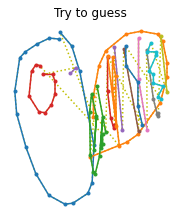

Top-5 predictions:
  1. bee 27.354%
  2. sea turtle 6.987%
  3. tennis racquet 6.755%
  4. steak 4.240%
  5. hedgehog 3.690%
Answer: raccoon


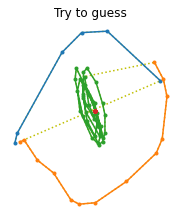

Top-5 predictions:
  1. eye 97.856%
  2. speedboat 0.407%
  3. mouth 0.168%
  4. whale 0.167%
  5. peas 0.156%
Answer: eye


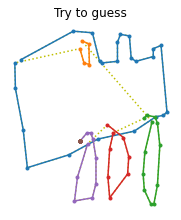

Top-5 predictions:
  1. pickup truck 33.154%
  2. truck 19.019%
  3. car 9.389%
  4. police car 7.180%
  5. train 4.366%
Answer: train


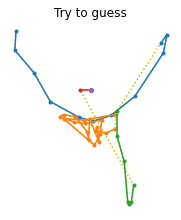

Top-5 predictions:
  1. goatee 61.498%
  2. speedboat 9.238%
  3. beard 4.370%
  4. arm 4.361%
  5. elbow 4.207%
Answer: goatee


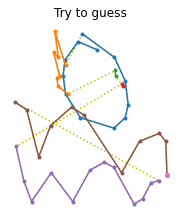

Top-5 predictions:
  1. speedboat 78.446%
  2. bat 2.063%
  3. submarine 2.032%
  4. pool 1.568%
  5. crocodile 1.522%
Answer: whale


In [123]:
n_new = 10
for sketches, labels in cropped_test_set.take(2):
    Y_probas = model_with_BN.predict(sketches)
    top_k = tf.nn.top_k(Y_probas, k=5)
    for index in range(n_new):
        plt.figure(figsize=(3, 3.5))
        draw_sketch(sketches[index])
        plt.show()
        print("Top-5 predictions:".format(index + 1))
        for k in range(5):
            class_name = class_names[top_k.indices[index, k]]
            proba = 100 * top_k.values[index, k]
            print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
        print("Answer: {}".format(class_names[labels[index].numpy()]))